# Sentiment Analysis COVID19 in Indonesia

## Preparation

### Import Libraries

In [ ]:
# Import Library Standard
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns

# Import Library Sklearn
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import RidgeClassifier, LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, plot_confusion_matrix
from sklearn.pipeline import make_pipeline

# Import Library untuk Stemming
!pip install Sastrawi
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

In [ ]:
import pandas as pd
df = pd.read_csv('imdb_indonesian_movies_2.csv', sep='\t')
df.head()

In [ ]:
# Read Dataset
data = pd.read_excel('Data_Sentimen.xlsx')
# data = pd.read_excel('Data_Sentimen.xlsx')
data.head()

,TYPE 1,USErNAME,Jumlah
0,Positif,Yuni,1
1,Negatif,Yuni,0
2,Netral,Yuni,1
3,Positif,Latifatul Mujahidah,7
4,Negatif,Latifatul Mujahidah,1


### Data Exploration

In [ ]:
df = data[['DATA SENTIMEN ( TWEET DARI TWITTER)', 'TYPE1']].copy()
df.rename(columns={'DATA SENTIMEN ( TWEET DARI TWITTER)':'komentar', 'TYPE1':'label'}, inplace=True)
print('Ukuran Dataset: ', df.shape)
df.head()

KeyError: ignored

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


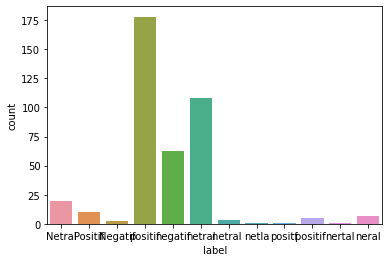

In [ ]:
import seaborn as sns
sns.countplot(df['label']);

In [ ]:
print("CONTOH KOMENTAR HASIL SCRAPPING\n")
for i in range(1,5):
      print(f"KOMENTAR{i}:\n {df['komentar'][i]}")

CONTOH KOMENTAR HASIL SCRAPPING

KOMENTAR1:
 10.30 #BeritaSONORA - Pengundian Nomor Urut Peserta Pilkada 2020, Gibran-Teguh Dapat Nomor Urut 1… https://t.co/QNBKQ8fDZW
KOMENTAR2:
 RT @KompasTV: Pengundian Nomor Urut Peserta Pilkada 2020, Gibran-Teguh Dapat Nomor Urut 1 https://t.co/jJxPbptSvE https://t.co/lHhsJuJom9
KOMENTAR3:
 Pengundian Nomor Urut Peserta Pilkada 2020, Gibran-Teguh Dapat Nomor Urut 1 https://t.co/jJxPbptSvE https://t.co/lHhsJuJom9
KOMENTAR4:
 Pengundian Nomor Urut Peserta Pilkada 2020, Gibran-Teguh Dapat Nomor Urut 1 https://t.co/jJxPbptSvE https://t.co/lHhsJuJom9


banyak komentar yang masih mengandung link http, spasi dan @akun sehingga perlu dibersihkan terlebih dahulu

## Preprocessing

### cleanning

In [ ]:
def clean_tweet(tweet):
    """ cleaning tweet 
    source code: https://www.machinelearningplus.com/python/python-regex-tutorial-examples/
    """
    tweet = re.sub('http\S+\s*', '', tweet)  # remove URLs
    tweet = re.sub('pic\.\S+', '', tweet)  # remove picture twitter URLs
    tweet = re.sub('RT|cc', '', tweet)  # remove RT and cc
    tweet = re.sub('#\S+', '', tweet)  # remove hashtags
    tweet = re.sub('@\S+', '', tweet)  # remove mentions
    tweet = re.sub('[%s]' % re.escape("""!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"""), '', tweet)  # remove punctuations
    tweet = re.sub('\s+', ' ', tweet)  # remove extra whitespace
    return tweet

In [ ]:
df['komentar'] = df['komentar'].apply(lambda x:clean_tweet(x))

In [ ]:
for i in range(9,11):
    print(f"Contoh sebelum cleaning:\n\t{data['DATA SENTIMEN ( TWEET DARI TWITTER)'][i]}")
    print(f"Contoh setelah cleaning:\n\t{df['komentar'][i]}\n")

Contoh sebelum cleaning:
	Resmi Ditetapkan KPU Kota Surakarta Dengan Nomor Urut 1, Gibran-Teguh Yakin Bakal Meraih Kemenangan… https://t.co/Vpi2FU4i3E
Contoh setelah cleaning:
	Resmi Ditetapkan KPU Kota Surakarta Dengan Nomor Urut 1 GibranTeguh Yakin Bakal Meraih Kemenangan… 

Contoh sebelum cleaning:
	calon walikota solo tuh emang gibran teguh doang? aku ga pernah liat baliho atau spanduk lawannya di sepanjang jala… https://t.co/3POCnFYIXX
Contoh setelah cleaning:
	calon walikota solo tuh emang gibran teguh doang aku ga pernah liat baliho atau spanduk lawannya di sepanjang jala… 



### Spell Correction

#### Stemming

In [ ]:
# Membuat stemmer
stemmerFactory = StemmerFactory()
stemmer = stemmerFactory.create_stemmer()

# Daftar Stopword
stopWordRemoverFactory = StopWordRemoverFactory()
stopwords = stopWordRemoverFactory.get_stop_words()

In [ ]:
df['komentar'] = df['komentar'].apply(lambda x: stemmer.stem(x))

In [ ]:
for i in range(300, 310):
    print(f"sebelum stemming:\n {data['DATA SENTIMEN ( TWEET DARI TWITTER)'][i]}")
    print(f"setelah stemming:\n {df['komentar'][i]}\n")

sebelum stemming:
 Gibran - Teguh untuk Solo Bermanfaat @ Kampoeng Batik Laweyan - Solo https://t.co/9Iklc2UcrC
setelah stemming:
 gibran teguh untuk solo manfaat kampoeng batik laweyan solo

sebelum stemming:
 Gibran - Teguh untuk Solo Bermanfaat @ Kampoeng Batik Laweyan - Solo https://t.co/6gT9fkXnCg
setelah stemming:
 gibran teguh untuk solo manfaat kampoeng batik laweyan solo

sebelum stemming:
 @Fahrihamzah @msaid_didu Awalnya purnomo_teguh dtengah jalan dtkung gibran purnomo gagal maju stlah dpanggil jkw..
setelah stemming:
 awal purnomoteguh dtengah jalan dtkung gibran purnomo gagal maju stlah dpanggil jkw

sebelum stemming:
 RT @CNNIndonesia: #DetikNetwork
Partai Gelombang Rakyat (Gelora) Indonesia mantap mendukung pasangan Gibran Rakabuming Raka-Teguh Prakoso d…
setelah stemming:
 partai gelombang rakyat gelora indonesia mantap dukung pasang gibran rakabuming rakateguh prakoso d

sebelum stemming:
 Hadirkan Paslon Gibran-Teguh dan Bagyo- Suparjo, Tokoh Lintas Agama di Solo Dek

In [ ]:
df_clean = pd.DataFrame()
df_clean['Komentar_scraping'] = data['DATA SENTIMEN ( TWEET DARI TWITTER)']
df_clean['Komentar_clean'] = df['komentar']
df_clean['label'] = df['label']
df_clean.head(5)

,Komentar_scraping,Komentar_clean,label
0,Pengambilan nomer urut paslon Pilkada Solo #id...,ambil nomer urut paslon pilkada solo,Netral
1,10.30 #BeritaSONORA - Pengundian Nomor Urut Pe...,1030 undi nomor urut serta pilkada 2020 gibran...,Positif
2,RT @KompasTV: Pengundian Nomor Urut Peserta Pi...,undi nomor urut serta pilkada 2020 gibranteguh...,Positif
3,"Pengundian Nomor Urut Peserta Pilkada 2020, Gi...",undi nomor urut serta pilkada 2020 gibranteguh...,Netral
4,"Pengundian Nomor Urut Peserta Pilkada 2020, Gi...",undi nomor urut serta pilkada 2020 gibranteguh...,Netral


In [ ]:
df_clean.to_excel("cleaning_data.xlsx")

In [ ]:
# pemisahan feature dan label
X = df['komentar']
y = df['label']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1)
print(f"training size {X_train.size}")
print(f"validasi size {X_val.size}")

training size 359
validasi size 40


In [ ]:
sns.countplot(y_train)
plt.title('Data Training')

NameError: ignored

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Data Validasi')

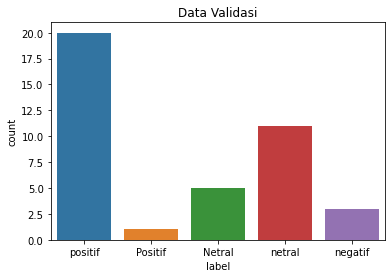

In [ ]:
sns.countplot(y_val)
plt.title('Data Validasi')